# OptiML Project - Text classification models optimization

## Imports

In [1]:
import random
from collections import namedtuple, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange
# from tqdm import tqdm, trange
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoConfig

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using GPU')
else:
    raise Exception('Using CPU')

Using GPU


## Setup the seed
For reproducibility purposes, we will set the seed of the random number generators

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)


seed = 42
seed_everything(seed)

## Load the data

In [4]:
dataset = load_dataset('cwchang/text-classification-dataset-example')
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 7500
    })
})

In [5]:
pd.DataFrame(dataset['train'])

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


### Preprocessing

In [6]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 15000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 3000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 7500
 }))

In [7]:
pd.DataFrame(train_dataset)

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


In [8]:
pd.DataFrame(val_dataset)

,label,text,id
0,cook_time,how long should i cook steak for,eval-0
1,balance,please tell me how much money i have in my ban...,eval-1
2,gas,what is the gas level in my gas tank,eval-2
3,time,how late is it now in ourense,eval-3
4,car_rental,i really need to get a volkswagen car rental f...,eval-4
...,...,...,...
2995,current_location,please tell me the address of my current location,eval-2995
2996,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
2997,change_volume,please turn your volume up,eval-2997
2998,improve_credit_score,show me a plan to help my credit score rating,eval-2998


In [9]:
pd.DataFrame(test_dataset)

,label,text,id
0,bill_balance,how much are my rent and cable,test-0
1,restaurant_suggestion,i need some suggestions for dinner places tonight,test-1
2,report_lost_card,can you report a lost card for me,test-2
3,timezone,timezone currently in mobile,test-3
4,what_is_your_name,tell me what to call you,test-4
...,...,...,...
7495,current_location,please tell me the address of my current location,eval-2995
7496,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
7497,change_volume,please turn your volume up,eval-2997
7498,improve_credit_score,show me a plan to help my credit score rating,eval-2998


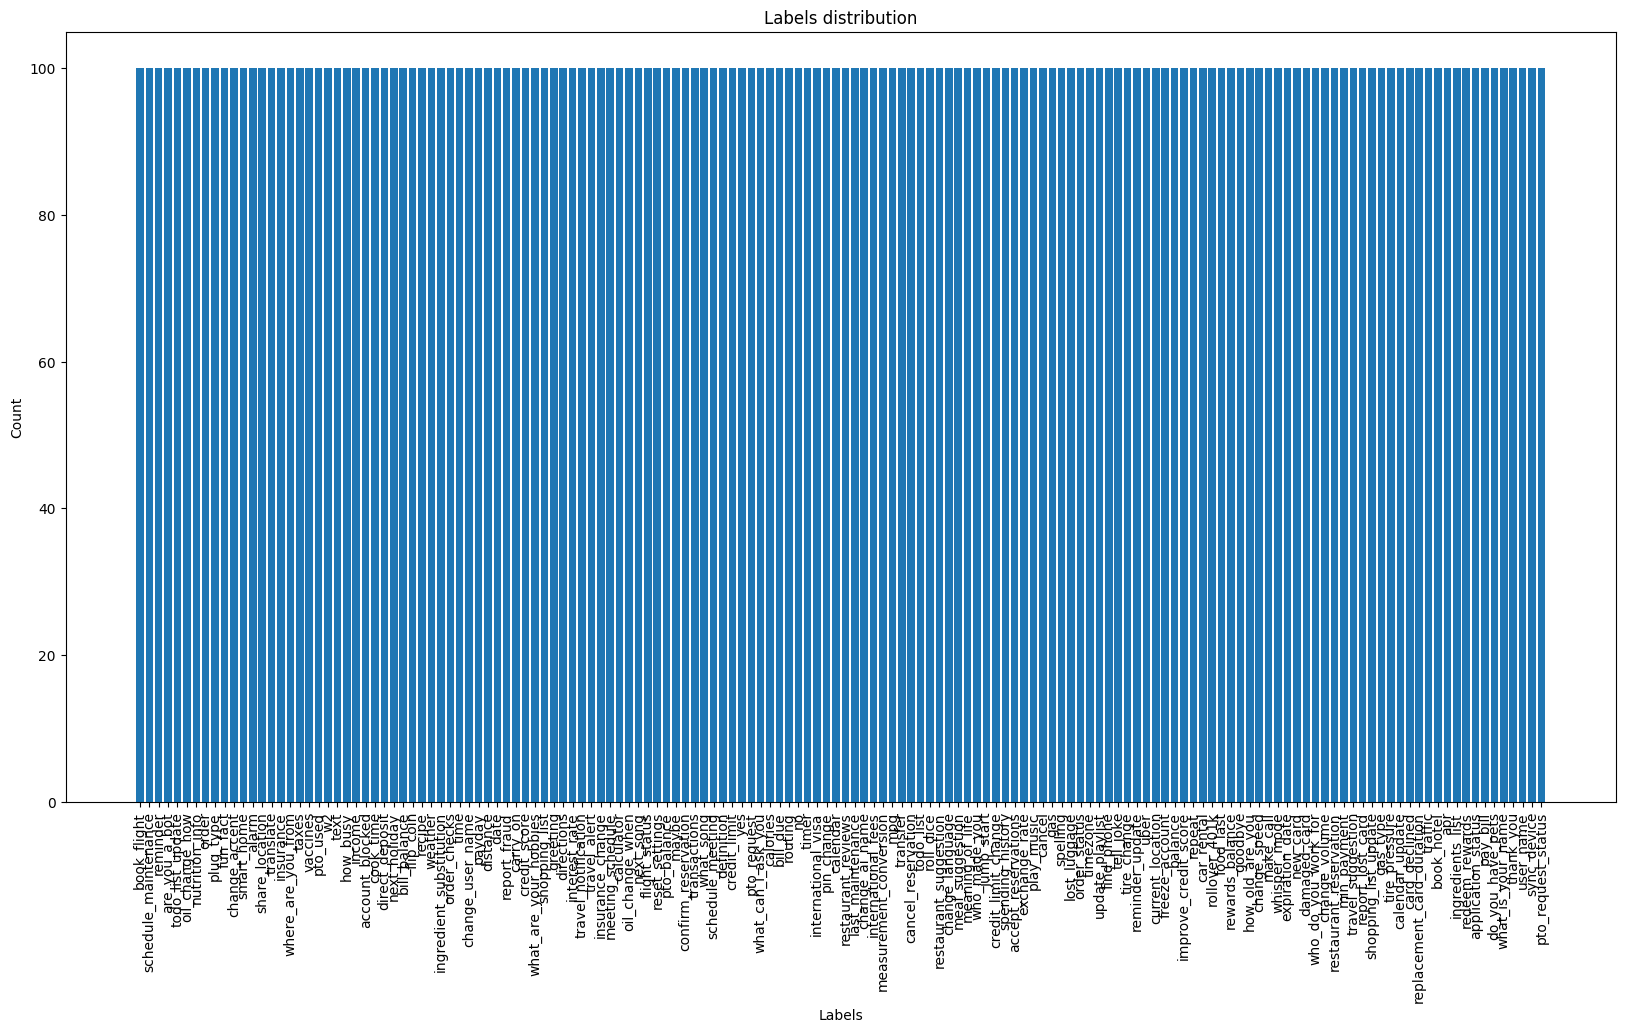

In [10]:
labels_counter = Counter([d['label'] for d in train_dataset])
plt.figure(figsize=(20, 10))
plt.bar(labels_counter.keys(), labels_counter.values())
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Labels distribution')
plt.show()

In [11]:
classes = list(set(train_dataset['label']))
label2id = {c: i for i, c in enumerate(classes)}
id2label = {i: c for c, i in label2id.items()}
num_labels = len(classes)
pd.DataFrame({'class': list(classes), 'idx': list(label2id.values())})

,class,idx
0,last_maintenance,0
1,change_ai_name,1
2,jump_start,2
3,where_are_you_from,3
4,insurance_change,4
...,...,...
145,taxes,145
146,replacement_card_duration,146
147,thank_you,147
148,update_playlist,148


In [12]:
num_labels

150

## Load pretrained model (RoBERTa)

In [13]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare dataloaders

In [14]:
def prepare_dataset(dataset):
    texts = [d['text'] for d in dataset]
    tokenized = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    labels_ids = [label2id[d['label']] for d in dataset]
    labels = torch.tensor(labels_ids).to(device)
    return TensorDataset(tokenized['input_ids'], tokenized['attention_mask'], labels)

In [15]:
train_tokenized = prepare_dataset(train_dataset)
train_dataloader = DataLoader(train_tokenized, batch_size=8, shuffle=True)

In [16]:
val_tokenized = prepare_dataset(val_dataset)
val_dataloader = DataLoader(val_tokenized, batch_size=8, shuffle=False)

In [17]:
test_tokenized = prepare_dataset(test_dataset)
test_dataloader = DataLoader(test_tokenized, batch_size=8, shuffle=False)

## Training and evaluation functions

In [18]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          scheduler: optim.lr_scheduler._LRScheduler,
          num_epochs: int):
    seed_everything(seed)
    if scheduler is None:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
    t = trange(num_epochs)
    train_losses = []
    val_losses = []
    accs = []
    for epoch in t:
        train_loss = 0
        model.zero_grad()
        optimizer.zero_grad()
        model.train()
        for X_batch, attention_mask, y_batch in tqdm(train_dataloader, leave=False):
            model.zero_grad()
            optimizer.zero_grad()
            outputs = model(X_batch, attention_mask=attention_mask, labels=y_batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        model.eval()
        acc, val_loss, _ = evaluate(model, val_dataloader)
        scheduler.step()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accs.append(acc)
        t.set_postfix(train_loss=train_loss, val_loss=val_loss, acc=acc)
    return namedtuple('Training', ['train_losses', 'val_losses', 'accs'])(train_losses, val_losses, accs)


def plot_training(training):
    """
    Plot 2 different graphs : the training and validation losses and the validation accuracy
    :param training: namedtuple('Training', ['train_losses', 'val_losses', 'accs'])
    :return: None
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(training.train_losses, label='Train loss')
    ax[0].plot(training.val_losses, label='Val loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and validation losses')
    ax[0].legend()
    ax[1].plot(training.accs, label='Val accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Validation accuracy')
    ax[1].legend()
    plt.show()


def evaluate(model: nn.Module,
             test_dataloader: torch.utils.data.DataLoader):
    model.eval()
    confusion_matrix = np.zeros((num_labels, num_labels))
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, attention_mask, y_batch in tqdm(test_dataloader, leave=False):
            outputs = model(X_batch, attention_mask=attention_mask, labels=y_batch)
            loss = outputs.loss
            test_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            for t, p in zip(y_batch.view(-1), predicted.view(-1)):
                confusion_matrix[p.long(), t.long()] += 1
    acc = correct / total
    test_loss /= len(test_dataloader)
    return namedtuple('Evaluation', ['accuracy', 'loss', 'confusion_matrix'])(acc, test_loss, confusion_matrix)


def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(30, 30))
    plt.imshow(confusion_matrix, cmap='Reds', interpolation='nearest')
    plt.xticks(np.arange(num_labels), classes, rotation=90)
    plt.yticks(np.arange(num_labels), classes)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

## Hyperparameters

In [19]:
num_epochs = 5
learning_rate = 5e-5
_optimizer = optim.AdamW

## Fine-tuning the model 

In [20]:
optimizer = _optimizer(model.parameters(), lr=learning_rate)

In [21]:
training = train(model=model,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 scheduler=None,
                 num_epochs=num_epochs)
training

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Training(train_losses=[1.5224101687312126, 0.26326314221968256, 0.1711475168575843, 0.15864822247152527, 0.12042727807660898], val_losses=[0.4084343891342481, 0.28951707449555397, 0.275026424108694, 0.32709761072695254, 0.284393163461859], accs=[0.9133333333333333, 0.93, 0.942, 0.941, 0.9426666666666667])

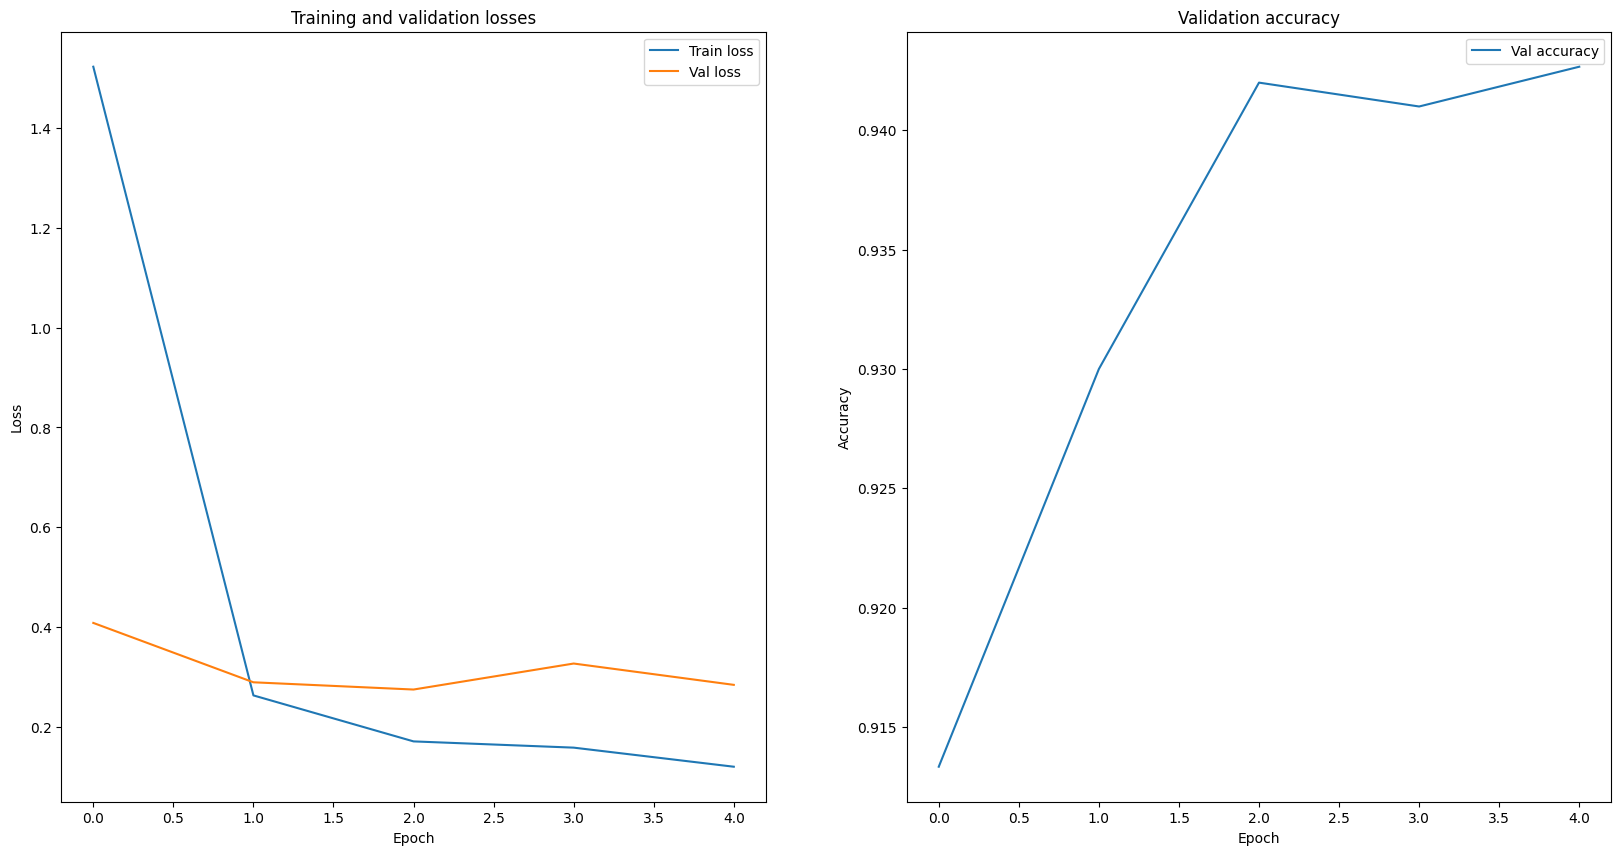

In [22]:
plot_training(training)

In [23]:
evaluation = evaluate(model, test_dataloader)
evaluation

  0%|          | 0/938 [00:00<?, ?it/s]

Evaluation(accuracy=0.9404, loss=0.28699860767697666, confusion_matrix=array([[49.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 46.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 50., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 50.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0., 47.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 46.]]))

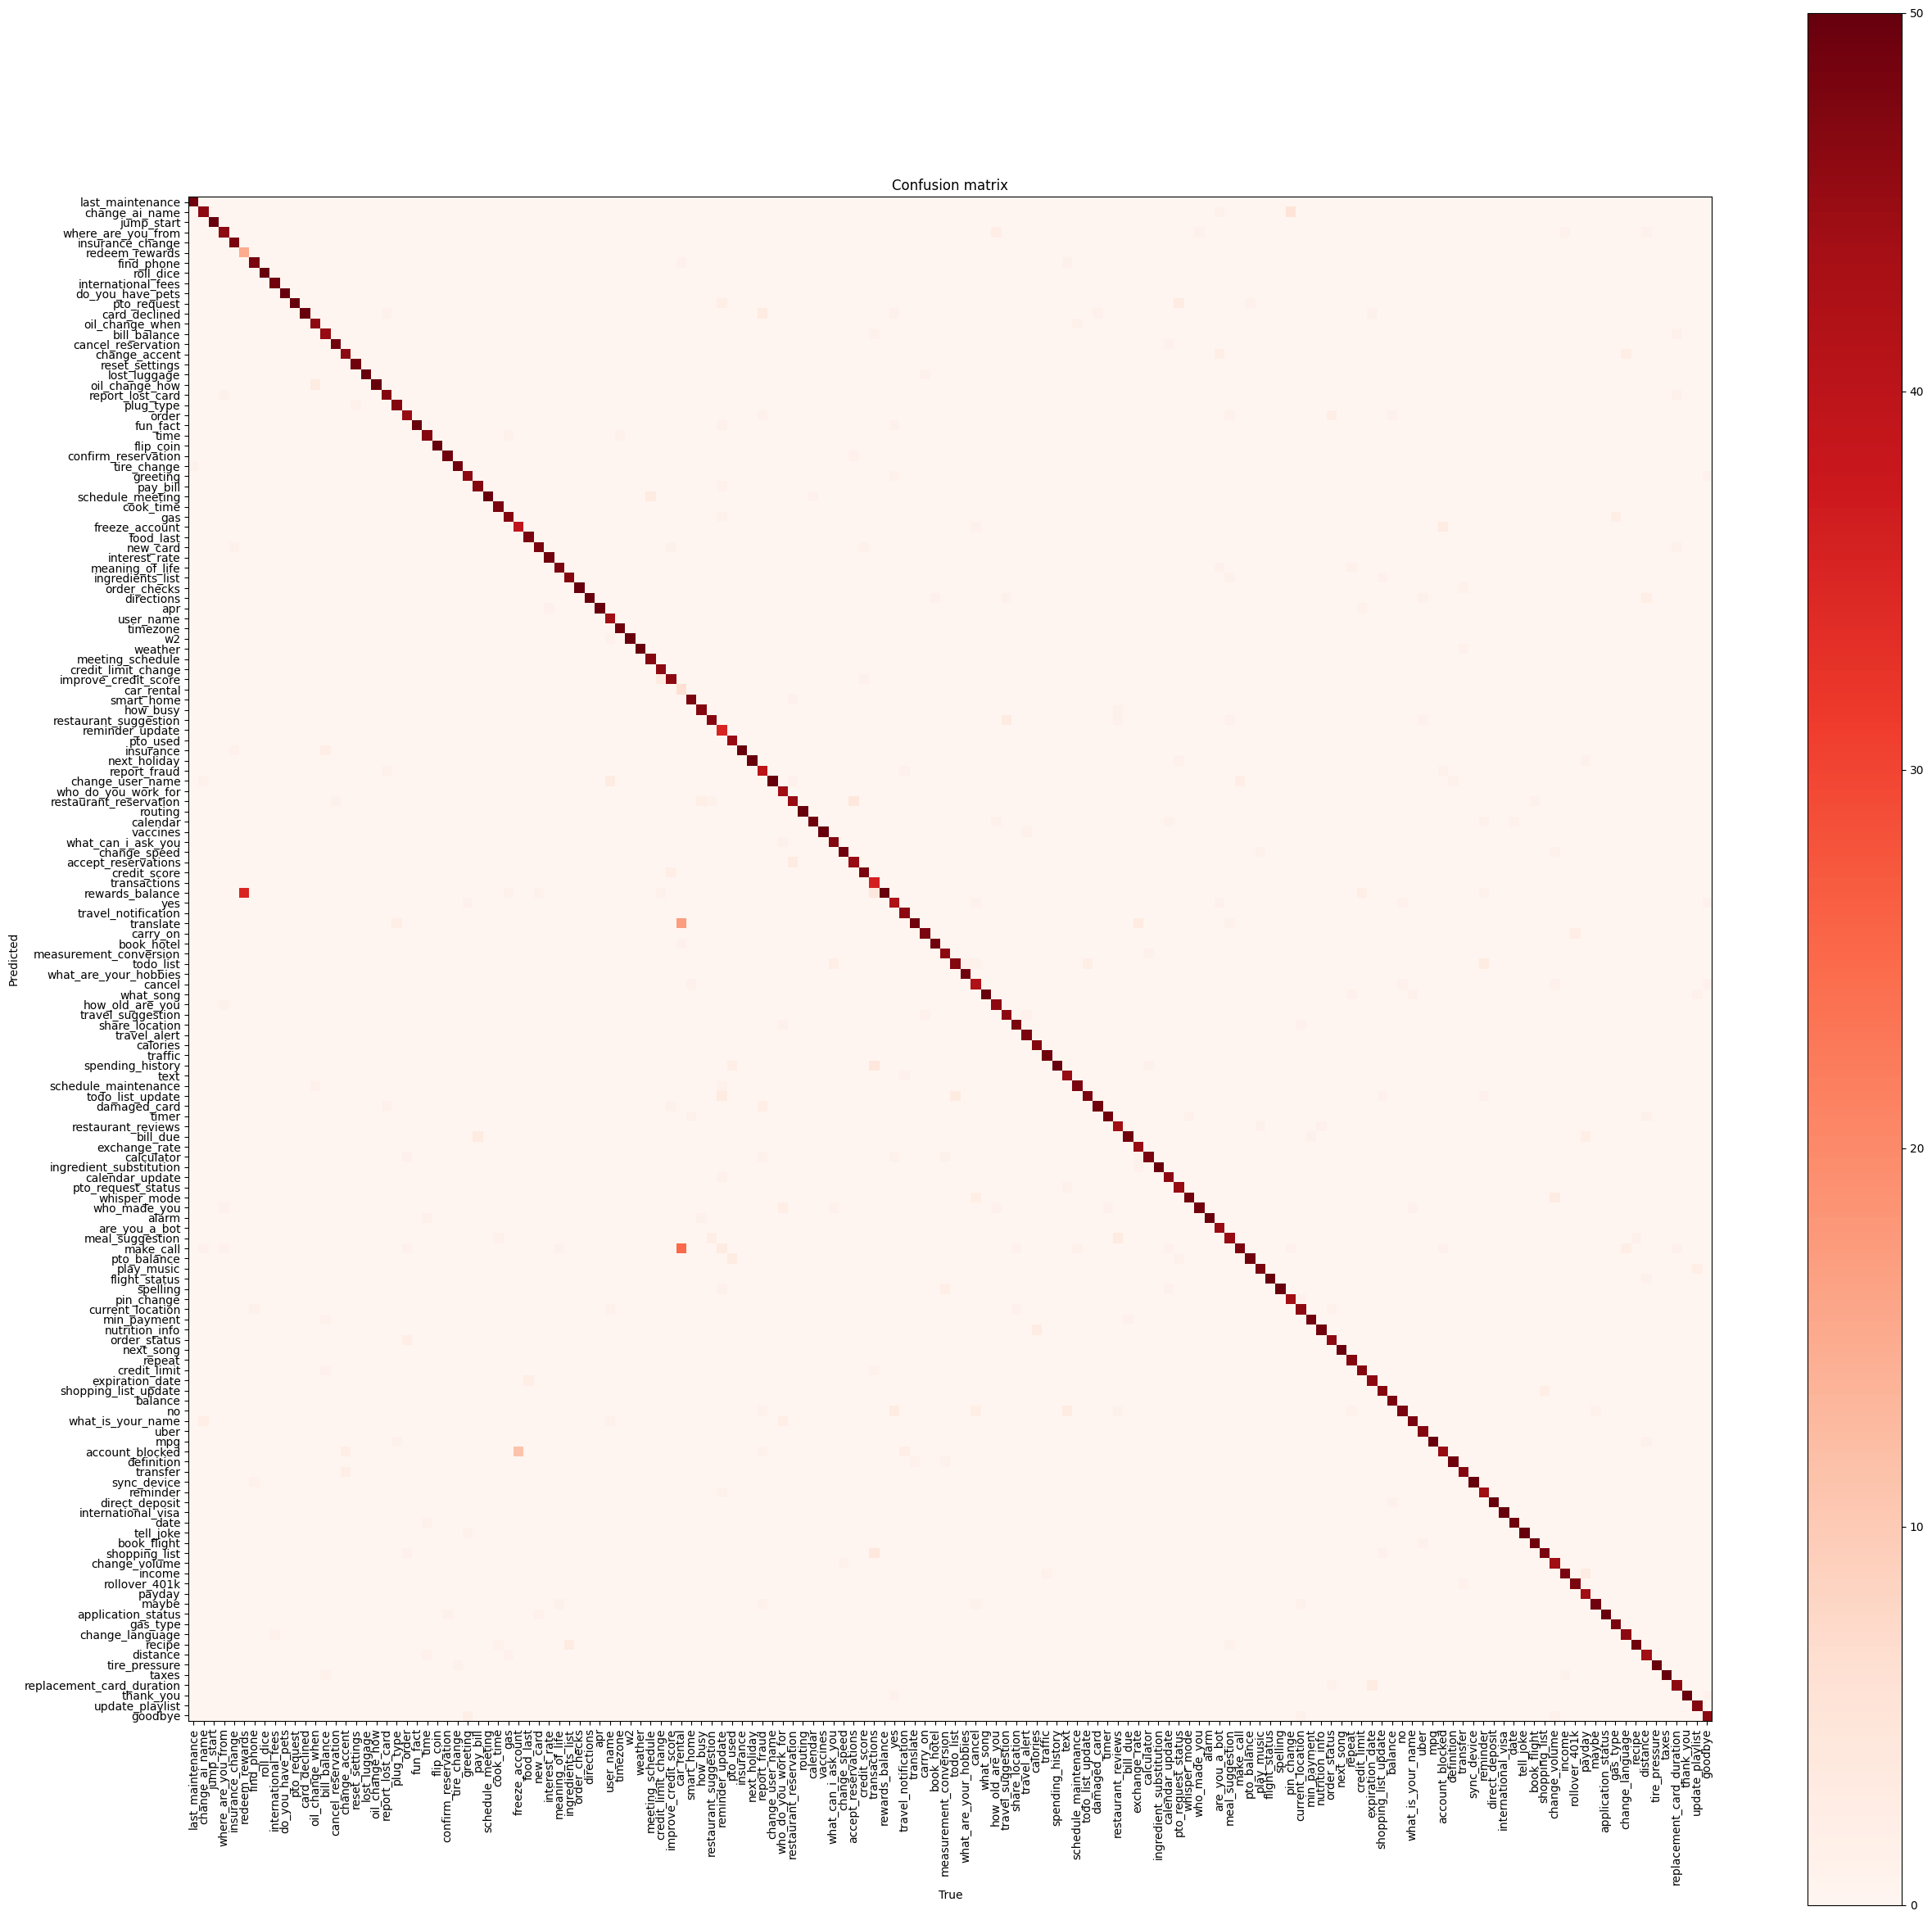

In [24]:
plot_confusion_matrix(evaluation.confusion_matrix)